# Species / Breed Statistics

In [10]:
import pandas as pd

In [11]:
invoice = pd.read_csv('/home/yuhuiz/csu/species/invoice.csv', sep='\t', low_memory=False)

In [12]:
final_csu = pd.read_csv('/home/yuhuiz/csu/species/final_csu_file_snomed', sep='\t', low_memory=False)

In [13]:
snomed_id_to_name = {}
with open('/home/yuhuiz/csu/species/combined_desc.txt') as f:
    for i, line in enumerate(f):
        tups = line.split('\t')
        snomed_id_to_name[tups[4]] = tups[7]

In [14]:
species_id_to_name = {}
with open('/home/yuhuiz/csu/species/sno_species.csv') as f:
    for i, line in enumerate(f):
        if i == 0:
            continue
        tups = line.split(',')
        species_id_to_name[tups[0]] = tups[2].strip()

In [15]:
species_id_to_name

{'125090003': 'BOVINE',
 '125083008': 'EQUINE',
 '125088004': 'PORCINE',
 '125100005': 'OVINE',
 '125098005': 'CAPRINE',
 '125079008': 'CANINE',
 '125081005': 'FELINE',
 '0': 'MAMMAL'}

In [16]:
breed_id_to_name = {}
with open('/home/yuhuiz/csu/species/sno_breed.csv') as f:
    for i, line in enumerate(f):
        if i == 0:
            continue
        tups = line.split(',')
        breed_id_to_name[tups[2]] = tups[3].strip().lower()

In [17]:
breed_id_to_name

{'300004': 'minsch',
 '507002': 'stdpdl',
 '1514007': 'bdlter',
 '2062007': 'dach',
 '3347005': 'ddter',
 '3674001': 'husky',
 '3921008': 'ardale',
 '5306005': 'manter',
 '5916008': 'dalm',
 '6103004': 'jrterr',
 '8351009': '',
 '9528004': 'f-cret',
 '9761009': 'chi',
 '10040000': 'pom',
 '10369004': 'briard',
 '10842007': 'ibizhd',
 '11477006': 'irset',
 '11746005': 'auheel',
 '12091005': 'britsp',
 '12131006': 'minpin',
 '12390000': 'stfter',
 '13248002': 'chbret',
 '13284009': 'yorkie',
 '13942005': 'mantty',
 '14245006': 'rottwr',
 '14876008': 'phrhnd',
 '17663009': 'tibter',
 '19078005': 'collie',
 '21039009': 'puli',
 '21150005': 'skipke',
 '21418008': 'engcoc',
 '22697009': 'cocker',
 '23995009': 'bulter',
 '24299002': 'skye',
 '25171009': 'rbhnd',
 '25243005': 'toypdl',
 '25264009': 'gwpont',
 '26229008': 'tollng',
 '26639007': 'tfxter',
 '27385008': 'fldspn',
 '27444002': 'belter',
 '27615007': 'dane',
 '28751008': 'chow',
 '30347000': 'itgrhd',
 '31077009': 'shihtz',
 '312810

In [18]:
invoice_number_breed_species_map = {}
# {invoice_number: [breed, species]}

import csv

with open('/home/yuhuiz/csu/species/invoice.csv') as f:
    csv_reader = csv.reader(f, delimiter='\t')
    for i, tups in enumerate(csv_reader):
        if i == 0:
            continue
        assert tups[0] not in invoice_number_breed_species_map
        invoice_number_breed_species_map[tups[0]] = (species_id_to_name[tups[4]], breed_id_to_name[tups[5]])

In [20]:
len(invoice_number_breed_species_map)

264404

In [21]:
from collections import defaultdict

species_to_disease = defaultdict(list) # {species: [diseases]}
breeds_to_disease = defaultdict(list)

species_freq = []
breed_freq = []

found = 0
with open('/home/yuhuiz/csu/species/final_csu_file_snomed') as f:
    for line in f:
        tups = line.split('\t')
        invoice_number = tups[3]
        if invoice_number in invoice_number_breed_species_map:
            species, breed = invoice_number_breed_species_map[invoice_number]
            diseases = tups[5].split("|")  # actually applied SNOMED codes
            species_to_disease[species].extend(diseases)
            breeds_to_disease[breed].extend(diseases)
            found += 1
            species_freq.append(species)
            breed_freq.append(breed)

In [22]:
found  # basically everything is in there

112557

In [23]:
from collections import Counter
Counter(species_freq)

Counter({'CANINE': 86995,
         'FELINE': 13181,
         'EQUINE': 10155,
         'OVINE': 84,
         'PORCINE': 386,
         'BOVINE': 1240,
         'CAPRINE': 372,
         'MAMMAL': 144})

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

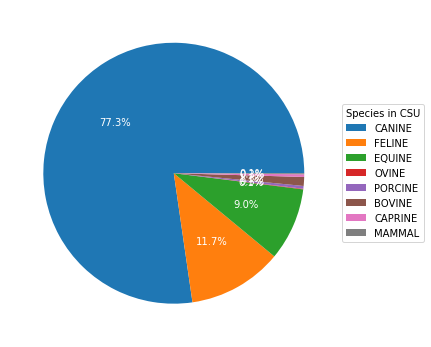

In [25]:
import numpy as np

def func(pct, allvals):
    absolute = int(pct/np.sum(list(allvals.values())))
    return "{:.1f}%".format(pct, absolute)

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(Counter(species_freq).values(), autopct=lambda pct: func(pct, Counter(species_freq)),
                                  textprops=dict(color="w"))

ax.legend(wedges, list(Counter(species_freq).keys()),
          title="Species in CSU",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

In [28]:
for k, v in Counter(species_freq).items():
    print(k, "{:.2f}".format(v / sum(Counter(species_freq).values()) * 100))

CANINE 77.29
FELINE 11.71
EQUINE 9.02
OVINE 0.07
PORCINE 0.34
BOVINE 1.10
CAPRINE 0.33
MAMMAL 0.13


In [27]:
species_to_disease_freq = {}
for k, l in species_to_disease.items():
    species_to_disease_freq[k] = defaultdict(int)
    for d in l:
        if d.replace('R', '').replace('S', '') in snomed_id_to_name:
            name = snomed_id_to_name[d.replace('R', '').replace('S', '')]
            if '(disorder)' in name:
                species_to_disease_freq[k][name] += 1

sorted_species_to_disease_freq = {}
for k, freq_dict in species_to_disease_freq.items():
    sorted_freq_dict = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:10] # top 10 diseases
    sorted_species_to_disease_freq[k] = sorted_freq_dict

**PP dataset**

In [30]:
import csv

pp_species_freq = []
pp_breed_freq = []

pp_species_to_disease = defaultdict(list) # {species: [diseases]}
pp_breeds_to_disease = defaultdict(list)

found = 0

# with open('./adobe_DJ.csv', encoding='ISO-8859-1') as f:
with open('/home/yuhuiz/csu/2018-06-08-Adobe_data_final_snomed_combined.csv', encoding='ISO-8859-1') as f:
    csv_reader = csv.reader(f)
    for i, line in enumerate(csv_reader):
        if i == 0:
            continue
            
        diseases = []
        for group in line[19:]:
            if group != "":
                diseases.extend(group.split('|'))
                
        if len(diseases) > 0:
            pp_species_freq.append(line[5])
            pp_breed_freq.append(line[6])
            
            pp_species_to_disease[line[5]].extend(diseases)
            pp_breeds_to_disease[line[6]].extend(diseases)
            
            found += 1

In [31]:
found

586

In [32]:
for i, j in Counter(pp_species_freq).items():
    print(i, '\t', j)

Canine 	 425
Feline 	 149
Cockatiel 	 1
Rabbit NOS 	 8
Domestic Guinea Pig 	 1
Chinchilla NOS 	 1
Ferret Sp. 	 1


In [33]:
for k, v in Counter(pp_species_freq).items():
    print(k, "{:.2f}".format(v / sum(Counter(pp_species_freq).values()) * 100))

Canine 72.53
Feline 25.43
Cockatiel 0.17
Rabbit NOS 1.37
Domestic Guinea Pig 0.17
Chinchilla NOS 0.17
Ferret Sp. 0.17


In [34]:
pp_species_to_disease_freq = {}
for k, l in pp_species_to_disease.items():
    pp_species_to_disease_freq[k] = defaultdict(int)
    for d in l:
        if d.replace('R', '').replace('S', '') in snomed_id_to_name:
            name = snomed_id_to_name[d.replace('R', '').replace('S', '')]
            if '(disorder)' in name:
                pp_species_to_disease_freq[k][name] += 1

pp_sorted_species_to_disease_freq = {}
for k, pp_freq_dict in pp_species_to_disease_freq.items():
    pp_sorted_freq_dict = sorted(pp_freq_dict.items(), key=lambda x: x[1], reverse=True)[:10] # top 10 diseases
    pp_sorted_species_to_disease_freq[k] = pp_sorted_freq_dict

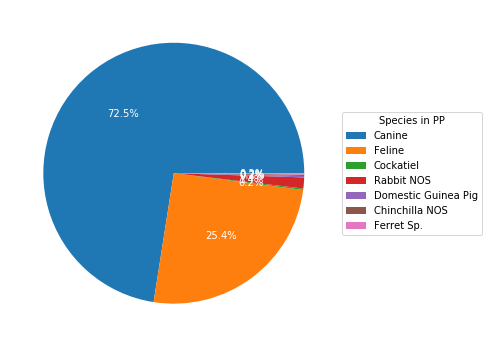

In [36]:
import numpy as np

def func(pct, allvals):
    absolute = int(pct/np.sum(list(allvals.values())))
    return "{:.1f}%".format(pct, absolute)

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(Counter(pp_species_freq).values(), autopct=lambda pct: func(pct, Counter(pp_species_freq)),
                                  textprops=dict(color="w"))

ax.legend(wedges, list(Counter(pp_species_freq).keys()),
          title="Species in PP",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))